In [7]:
# ==========================================
# CÉLULA RP1: INSTALAÇÃO E IMPORTAÇÕES
# ==========================================
# Instala biblioteca para baixar arquivos do Google Drive
!pip install -q gdown

import os
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
from sklearn.neighbors import NearestNeighbors
from glob import glob
import time

# Configurações de visualização
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas importadas com sucesso.")


Bibliotecas importadas com sucesso.


In [8]:
# ==========================================
# CÉLULA RP2: DOWNLOAD E CARREGAMENTO DOS DADOS
# ==========================================

def download_data():
    # IDs extraídos dos links fornecidos no enunciado
    dataset_id = '1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h'
    gt_id = '10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM'

    # Download do Dataset (ZIP)
    if not os.path.exists('dataset.zip'):
        print("Baixando dataset...")
        gdown.download(id=dataset_id, output='dataset.zip', quiet=False)

        # Deszipar
        print("Extraindo dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('kitti_data')

    # Download do Ground Truth (.npy)
    if not os.path.exists('ground_truth.npy'):
        print("Baixando Ground Truth...")
        gdown.download(id=gt_id, output='ground_truth.npy', quiet=False)

download_data()

In [9]:
# ==========================================
# CÉLULA DE CORREÇÃO: CARREGAMENTO DE ARQUIVOS .OBJ
# ==========================================
import os
import numpy as np
from glob import glob

# 1. Localizar arquivos .obj (Busca Profunda)
scan_files = []
# Varre todas as pastas dentro de kitti_data
for root, dirs, files in os.walk('kitti_data'):
    for file in files:
        # Procura arquivos que terminam com .obj
        if file.endswith('.obj'):
            full_path = os.path.join(root, file)
            scan_files.append(full_path)

# Ordenar a lista é CRUCIAL para garantir a sequência temporal (0, 1, 2...)
scan_files = sorted(scan_files)

print(f"Total de scans encontrados: {len(scan_files)}")

if len(scan_files) > 0:
    print(f"Primeiro arquivo: {scan_files[0]}")
    print(f"Último arquivo:   {scan_files[-1]}")
else:
    print("ERRO: Ainda não encontrou arquivos .obj. Verifique se o dataset.zip foi extraído.")

# 2. Redefinir a função de leitura para formato .OBJ
def load_pc(path):
    '''
    Lê um arquivo .obj onde os vértices são linhas começando com 'v'.
    Formato: v x y z
    '''
    points = []
    try:
        with open(path, 'r') as f:
            for line in f:
                # Linhas de vértice começam com 'v '
                if line.startswith('v '):
                    # Divide a linha em partes [v, x, y, z]
                    parts = line.strip().split()
                    # Converte x, y, z para float e adiciona à lista
                    points.append([float(parts[1]), float(parts[3]), float(parts[2])])

        return np.array(points, dtype=np.float32)
    except Exception as e:
        print(f"Erro ao ler {path}: {e}")
        return np.zeros((0, 3))

# Teste rápido para ver se está funcionando
if len(scan_files) > 0:
    test_pc = load_pc(scan_files[0])
    print(f"\nTeste de leitura do Scan 0:")
    print(f"Quantidade de pontos: {test_pc.shape[0]}")
    print(f"Exemplo de ponto (XYZ): {test_pc[0]}")

Total de scans encontrados: 30
Primeiro arquivo: kitti_data/000000/000000_points.obj
Último arquivo:   kitti_data/000029/000029_points.obj

Teste de leitura do Scan 0:
Quantidade de pontos: 62553
Exemplo de ponto (XYZ): [-9.110238  0.909355 18.6386  ]


In [10]:
# ==========================================
# CÉLULA 3.1: FUNÇÕES DO ALGORITMO ICP
# ==========================================
import numpy as np
from sklearn.neighbors import NearestNeighbors

def best_fit_transform(A, B):
    '''
    Calcula a rotação R e translação t que alinha A em B usando SVD (Algoritmo de Kabsch).
    Entrada: A (N,3), B (N,3)
    Saída: T (4,4)
    '''
    # 1. Centralizar as nuvens nos seus centróides
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    # 2. Matriz de covariância cruzada H = A^T * B
    H = np.dot(AA.T, BB)

    # 3. Decomposição em Valores Singulares (SVD)
    # U e Vt são matrizes ortogonais, S são os valores singulares
    U, S, Vt = np.linalg.svd(H)

    # 4. Calcular a Matriz de Rotação R
    R = np.dot(Vt.T, U.T)

    # 5. Correção para caso de reflexão (Determinante deve ser 1, não -1)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    # 6. Calcular Translação t
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # 7. Montar Matriz Homogênea Final T
    T = np.identity(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def icp(source, target, max_iterations=30, tolerance=0.001, sample_size=4000):
    '''
    Algoritmo Iterative Closest Point (ICP).
    Refina iterativamente a transformação para alinhar 'source' em 'target'.
    '''
    # -- Downsampling (Otimização de Performance) --
    if source.shape[0] > sample_size:
        idx_s = np.random.choice(source.shape[0], sample_size, replace=False)
        src = source[idx_s, :].copy()
    else:
        src = source.copy()

    if target.shape[0] > sample_size:
        idx_t = np.random.choice(target.shape[0], sample_size, replace=False)
        dst = target[idx_t, :].copy()
    else:
        dst = target.copy()

    # Cria coordenadas homogêneas para facilitar multiplicação de matrizes
    src_h = np.ones((src.shape[0], 4))
    src_h[:, :3] = src

    T_final = np.eye(4)
    prev_error = float('inf')

    # Usamos KD-Tree para busca rápida de vizinhos (apenas para associação)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(dst)

    for i in range(max_iterations):
        # Passo A: Encontrar correspondências (Nearest Neighbor)
        src_curr = src_h[:, :3] # Pega apenas x,y,z atuais
        distances, indices = nbrs.kneighbors(src_curr)

        target_correspondences = dst[indices.ravel()]

        # Passo B: Calcular transformação ótima para este passo (SVD)
        T_step = best_fit_transform(src_curr, target_correspondences)

        # Passo C: Aplicar a transformação aos pontos
        src_h = (np.dot(T_step, src_h.T)).T

        # Acumular a transformação na matriz final
        T_final = np.dot(T_step, T_final)

        # Passo D: Checar convergência (se o erro parou de diminuir)
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return T_final

print("Funções ICP e SVD definidas.")

Funções ICP e SVD definidas.


In [11]:
# ==========================================
# CÉLULA 3.2: LOOP DE PROCESSAMENTO (ODOMETRIA)
# ==========================================
import time

print("Iniciando estimativa de trajetória (ICP)...")
print(f"Processando {len(scan_files)} scans. Aguarde...")

# Pose inicial (Identidade 4x4)
current_pose = np.eye(4)
estimated_path = [current_pose]

start_time = time.time()

# Loop iterando par-a-par (t e t+1)
for i in range(len(scan_files) - 1):
    # Carregar nuvens
    source_cloud = load_pc(scan_files[i])     # Scan atual
    target_cloud = load_pc(scan_files[i+1])   # Próximo scan

    # Rodar ICP para descobrir como alinhar scan i em scan i+1
    T_rel = icp(source_cloud, target_cloud)

    # Atualizar Pose Global
    # A pose do carro é acumulada pela inversa da transformação dos pontos
    current_pose = np.dot(current_pose, np.linalg.inv(T_rel))

    estimated_path.append(current_pose)
    print(f"Scan {i} -> {i+1} processado.")

print(f"Concluído em {time.time() - start_time:.2f} segundos.")

# Converter lista para array numpy para facilitar plotagem
estimated_path = np.array(estimated_path)

Iniciando estimativa de trajetória (ICP)...
Processando 30 scans. Aguarde...
Scan 0 -> 1 processado.
Scan 1 -> 2 processado.
Scan 2 -> 3 processado.
Scan 3 -> 4 processado.
Scan 4 -> 5 processado.
Scan 5 -> 6 processado.
Scan 6 -> 7 processado.
Scan 7 -> 8 processado.
Scan 8 -> 9 processado.
Scan 9 -> 10 processado.
Scan 10 -> 11 processado.
Scan 11 -> 12 processado.
Scan 12 -> 13 processado.
Scan 13 -> 14 processado.
Scan 14 -> 15 processado.
Scan 15 -> 16 processado.
Scan 16 -> 17 processado.
Scan 17 -> 18 processado.
Scan 18 -> 19 processado.
Scan 19 -> 20 processado.
Scan 20 -> 21 processado.
Scan 21 -> 22 processado.
Scan 22 -> 23 processado.
Scan 23 -> 24 processado.
Scan 24 -> 25 processado.
Scan 25 -> 26 processado.
Scan 26 -> 27 processado.
Scan 27 -> 28 processado.
Scan 28 -> 29 processado.
Concluído em 15.12 segundos.


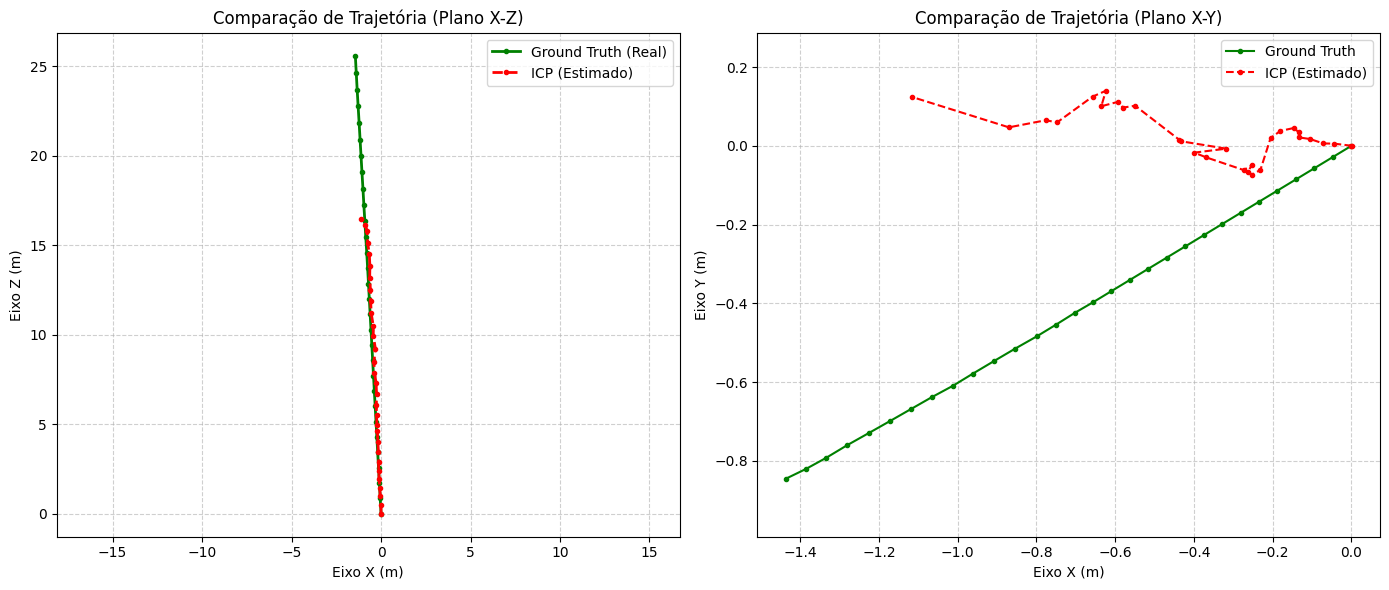

------------------------------
Posição Final Real (GT):     [-1.436633  -0.8456208 25.59694  ]
Posição Final Estimada:      [-1.11597214  0.1243503  16.46107568]
Erro de Posição Final:       9.1928 metros
------------------------------


In [13]:
# ==========================================
# CÉLULA 3.3: GRÁFICOS E COMPARAÇÃO COM GROUND TRUTH
# ==========================================
import matplotlib.pyplot as plt

# Carregar o Ground Truth (adicionado para corrigir NameError)
gt_poses = np.load('ground_truth.npy')

# 1. Extrair coordenadas da Trajetória Estimada
est_x = estimated_path[:, 0, 3]
est_y = estimated_path[:, 1, 3]
est_z = estimated_path[:, 2, 3]

# 2. Extrair coordenadas do Ground Truth (Real)
gt_x = gt_poses[:, 0, 3]
gt_y = gt_poses[:, 1, 3]
gt_z = gt_poses[:, 2, 3]

plt.figure(figsize=(14, 6))

# Plot A: Plano X-Z (Visão Superior Padrão em muitos datasets)
plt.subplot(1, 2, 1)
plt.plot(gt_x, gt_z, 'g.-', label='Ground Truth (Real)', linewidth=2)
plt.plot(est_x, est_z, 'r.--', label='ICP (Estimado)', linewidth=2)
plt.title('Comparação de Trajetória (Plano X-Z)')
plt.xlabel('Eixo X (m)')
plt.ylabel('Eixo Z (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Mantém a proporção real 1:1

# Plot B: Plano X-Y (Visão Lateral ou Alternativa)
plt.subplot(1, 2, 2)
plt.plot(gt_x, gt_y, 'g.-', label='Ground Truth')
plt.plot(est_x, est_y, 'r.--', label='ICP (Estimado)')
plt.title('Comparação de Trajetória (Plano X-Y)')
plt.xlabel('Eixo X (m)')
plt.ylabel('Eixo Y (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')

plt.tight_layout()
plt.show()

# 3. Cálculo de Erro Final (Euclidiano 3D na última posição)
final_pos_gt = gt_poses[-1, :3, 3]
final_pos_est = estimated_path[-1, :3, 3]
final_error = np.linalg.norm(final_pos_gt - final_pos_est)

print("-" * 30)
print(f"Posição Final Real (GT):     {final_pos_gt}")
print(f"Posição Final Estimada:      {final_pos_est}")
print(f"Erro de Posição Final:       {final_error:.4f} metros")
print("-" * 30)
